<a href="https://colab.research.google.com/github/khagerthey/GIS/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Plan
I plan on focusing my research around entrepreneurship. I feel with the useful tool of social media there has been an increase in small businesses. I’m interested in seeing how location within the United States has an effect on the type of businesses, location of buyer vs seller, and correlation between business and local cost of living.

#Resources
https://www.statista.com/statistics/1306812/number-us-etsy-sellers-state/
Here is usable data of the number of sellers in each state! (2021)

https://www.marketplacepulse.com/top-etsy-sellers
Here is usable data of top Etsy sellers! (countries)

US States shapefile link: https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5

2023 State population table link:
https://worldpopulationreview.com/states

In [7]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter()

import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
!pip install mapclassify
import mapclassify

In [84]:
state_population_raw=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/state-population-table.csv')
state_population_columns = state_population_raw[['state', 'pop2022']]
state_population = state_population_columns.rename(columns={'pop2022': 'Total Population 2022', 'state': 'US State'})
district_of_columbia = pd.DataFrame({'US State': ['District of Columbia'], 'Total Population 2022': [671803.0]})
puerto_rico = pd.DataFrame({'US State': ['Puerto Rico'], 'Total Population 2022': [3221789.0]})
combined_states = pd.concat([state_population, district_of_columbia, puerto_rico], ignore_index=True)

combined_states

,US State,Total Population 2022
0,California,39029342.0
1,Texas,30029572.0
2,Florida,22244823.0
3,New York,19677151.0
4,Pennsylvania,12972008.0
5,Illinois,12582032.0
6,Ohio,11756058.0
7,Georgia,10912876.0
8,North Carolina,10698973.0
9,Michigan,10034113.0


In [86]:
etsy_us_sellers=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/etsy_statessellerstats.csv', header=None)
etsy_us_sellers.columns=["US State", "Etsy Sellers in Thousands 2021"]
etsy_sellers = etsy_us_sellers.replace('Washington, D.C.', 'District of Columbia')
etsy_sellers

,US State,Etsy Sellers in Thousands 2021
0,California,465.6
1,Texas,337.3
2,Florida,302.4
3,New York,251.5
4,Pennsylvania,143.3
5,Illinois,133.9
6,Michigan,130.2
7,Ohio,130.1
8,Georgia,128.5
9,North Carolina,123.3


In [87]:
state_seller_compare = pd.merge(combined_states, etsy_sellers, how='outer', on=['US State'], indicator='true')
state_seller_compare
#everything merged correctly

,US State,Total Population 2022,Etsy Sellers in Thousands 2021,true
0,California,39029342.0,465.6,both
1,Texas,30029572.0,337.3,both
2,Florida,22244823.0,302.4,both
3,New York,19677151.0,251.5,both
4,Pennsylvania,12972008.0,143.3,both
5,Illinois,12582032.0,133.9,both
6,Ohio,11756058.0,130.1,both
7,Georgia,10912876.0,128.5,both
8,North Carolina,10698973.0,123.3,both
9,Michigan,10034113.0,130.2,both


In [75]:
#shapefile of US map states
! wget -q -O cb_2018_us_state_5m.zip https://github.com/khagerthey/GIS/raw/main/cb_2018_us_state_5m.zip


(-130.0, -65.0)

(20.0, 60.0)

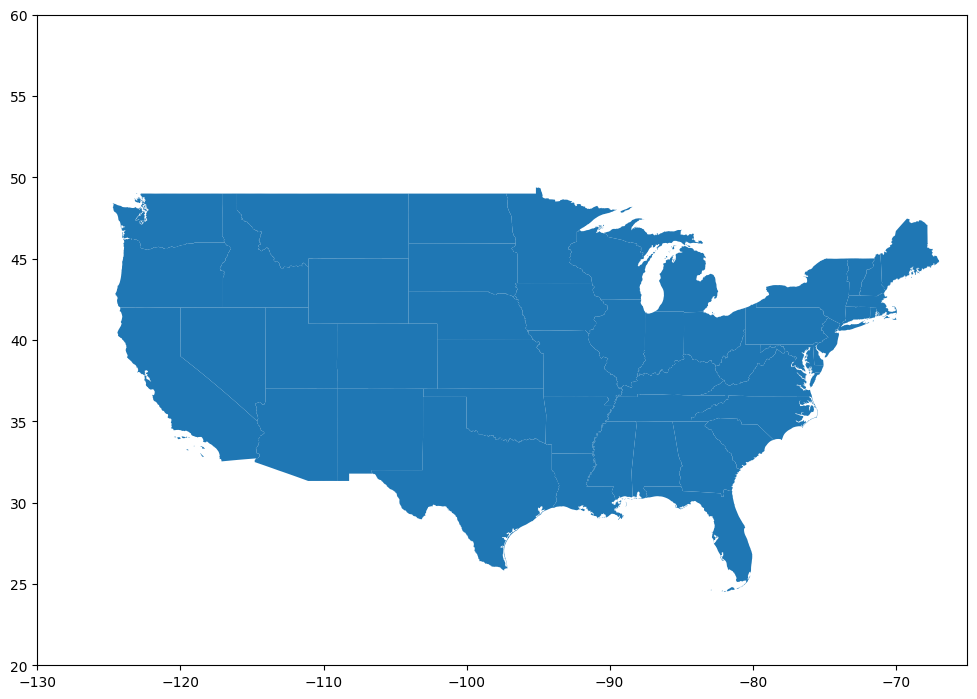

In [106]:
zip_ref = zipfile.ZipFile('cb_2018_us_state_5m.zip', 'r'); zip_ref.extractall(); zip_ref.close() #unzipping
states_map = gpd.read_file('cb_2018_us_state_5m.shp')

ax = states_map.plot(figsize = (12,12))
ax.set_xlim(-130, -65)
ax.set_ylim(20, 60)

In [110]:
continental_map_data =states_map.join(state_seller_compare.set_index("US State"), on="NAME")

<Axes: >

(-130.0, -65.0)

(20.0, 60.0)

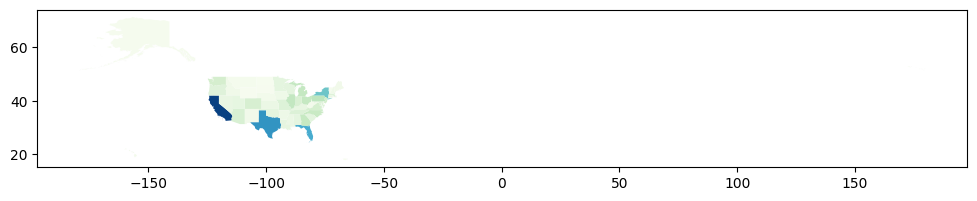

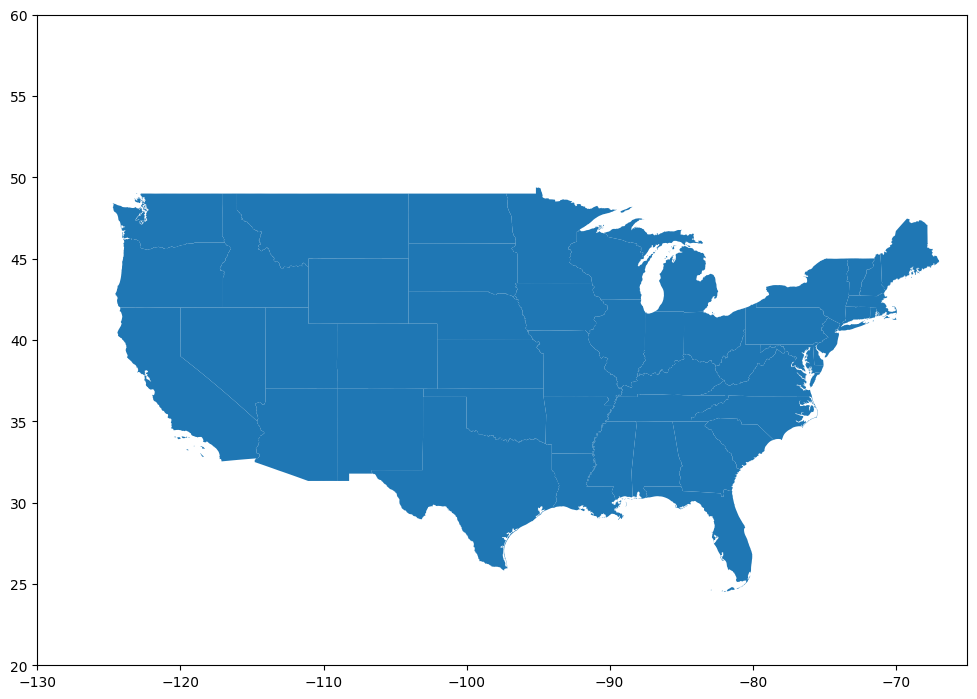

In [115]:
continental_map_data.plot(column="Etsy Sellers in Thousands 2021", cmap="GnBu", figsize=(12,12))
ax = continental_map_data.plot(figsize = (12,12))
ax.set_xlim(-130, -65)
ax.set_ylim(20, 60)

In [96]:
states_map.dtypes

STATEFP       object
STATENS       object
AFFGEOID      object
GEOID         object
STUSPS        object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

US states map will be used to input the data above. This will visualize the amount of sellers in each state within the US. After visualizing, the next step will to deeper research as to why specific states have a much higher amount.

To do:

- I want a better us states map to use (closer up)

- need to decide on second dataset for the merge
    - refer to google doc

- place data on map